In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import quandl
quandl.ApiConfig.api_key = "K42xtcTyEM7To-P_MwmN"
import torch.nn as nn
import torch
from torch.autograd import Variable
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
DEVICE = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
# Globals

INPUT_SIZE = 60
HIDDEN_SIZE = 64
NUM_LAYERS = 2
OUTPUT_SIZE = 1

# Hyper parameters

learning_rate = 0.001
num_epochs = 50

In [4]:
# Importing the training set
dataset_train = quandl.get("WIKI/TSLA")
training_set = dataset_train.iloc[:, 0:1].values

# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [5]:
# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(INPUT_SIZE, len(training_set)):
    X_train.append(training_set_scaled[i-INPUT_SIZE:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1])) #1-10, 2-11, 3-12

In [6]:
len(training_set)

1949

In [7]:
class RNN(nn.Module):
    def __init__(self, i_size, h_size, n_layers, o_size):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(
            input_size=i_size,
            hidden_size=h_size,
            num_layers=n_layers
        )
        self.out = nn.Linear(h_size, o_size)

    def forward(self, x, h_state):
        r_out, hidden_state = self.rnn(x, h_state)
        
        hidden_size = hidden_state[-1].size(-1)
        r_out = r_out.view(-1, hidden_size)
        outs = self.out(r_out)

        return outs, hidden_state

In [8]:
rnn = RNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE)
rnn = rnn.to(DEVICE)
optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

hidden_state = None



In [9]:
for epoch in range(num_epochs):
    inputs = Variable(torch.from_numpy(X_train).float())
    labels = Variable(torch.from_numpy(y_train).float())

    output, hidden_state = rnn(inputs, hidden_state) 

    loss = criterion(output.view(-1), labels)
    optimiser.zero_grad()
    loss.backward(retain_graph=True)                     # back propagation
    optimiser.step()                                     # update the parameters
    
    print('epoch {}, loss {}'.format(epoch,loss.item()))

epoch 0, loss 0.2012861967086792
epoch 1, loss 0.15050646662712097
epoch 2, loss 0.10295256972312927
epoch 3, loss 0.06026068329811096
epoch 4, loss 0.02652723528444767
epoch 5, loss 0.008980032056570053
epoch 6, loss 0.015008007176220417
epoch 7, loss 0.03277653083205223
epoch 8, loss 0.03783019632101059
epoch 9, loss 0.031000947579741478
epoch 10, loss 0.020837461575865746
epoch 11, loss 0.01310686394572258
epoch 12, loss 0.009690245613455772
epoch 13, loss 0.00989818386733532
epoch 14, loss 0.0120524438098073
epoch 15, loss 0.014559385366737843
epoch 16, loss 0.01637713424861431
epoch 17, loss 0.017042145133018494
epoch 18, loss 0.016518916934728622
epoch 19, loss 0.01504202838987112
epoch 20, loss 0.012995394878089428
epoch 21, loss 0.010821118019521236
epoch 22, loss 0.008940255269408226
epoch 23, loss 0.007674684748053551
epoch 24, loss 0.007173516787588596
epoch 25, loss 0.007365189492702484
epoch 26, loss 0.00796901248395443
epoch 27, loss 0.008589088916778564
epoch 28, loss 0.

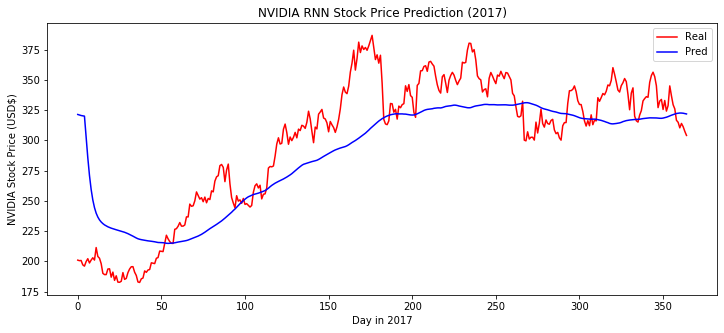

In [10]:
# Getting the real stock price of 2017
real_stock_price = dataset_train.iloc[:, 1:2][-365:].values

# Getting the predicted stock price of 2017
dataset_total = pd.concat((dataset_train['Open'], dataset_train['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(real_stock_price) - INPUT_SIZE:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(INPUT_SIZE, 420):
    X_test.append(inputs[i-INPUT_SIZE:i, 0])  
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

X_train_X_test = np.concatenate((X_train, X_test),axis=0)
hidden_state = None
test_inputs = Variable(torch.from_numpy(X_train_X_test).float())
predicted_stock_price, b = rnn(test_inputs, hidden_state)
predicted_stock_price = np.reshape(predicted_stock_price.detach().numpy(), (test_inputs.shape[0], 1))
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

real_stock_price_all = np.concatenate((training_set[INPUT_SIZE:], real_stock_price))

# Visualising the results
plt.figure(1, figsize=(12, 5 ))
plt.plot(training_set[-365:], color = 'red', label = 'Real')
plt.plot(predicted_stock_price[-365:], color = 'blue', label = 'Pred')
plt.title('NVIDIA RNN Stock Price Prediction (2017)')
plt.xlabel('Day in 2017')
plt.ylabel('NVIDIA Stock Price (USD$)')
plt.legend()
plt.show()

In [6]:
# Model score
score = round(mean_absolute_error(predicted_stock_price[-365:], training_set[-365:]), 4)
accuracy= str(score)
print('Training accuracy: ' + accuracy + '%')

NameError: name 'predicted_stock_price' is not defined

In [5]:
#Model MSE
score2 = round(mean_absolute_error(predicted_stock_price[-365:], training_set[-365:]), 4)

NameError: name 'predicted_stock_price' is not defined